In [1]:
import pandas as pd
import folium as f
from folium.plugins import FloatImage
import requests
import gpxpy
import branca
import numpy as np
import os
import io
import base64
from PIL import Image

In [2]:
def process_gpx_to_df(file_name): 

    gpx = gpxpy.parse(open(file_name))
    #(1)make DataFrame
    track = gpx.tracks[0]
    segment = track.segments[0]
    # Load the data into a Pandas dataframe (by way of a list)
    data = []
    segment_length = segment.length_3d()
    for point_idx, point in enumerate(segment.points):
        data.append([point.longitude, point.latitude,point.elevation,
    point.time, segment.get_speed(point_idx)])
    columns = ["Longitude", "Latitude", "Altitude", "Time", "Speed"]
    gpx_df = pd.DataFrame(data, columns=columns)

    #2(make points tuple for line)
    points = []
    for track in gpx.tracks:
        for segment in track.segments: 
            for point in segment.points:
                points.append(tuple([point.latitude, point.longitude]))

    return gpx_df, points

In [3]:
escursioniDF = pd.read_csv("EscursioniCAI.csv", sep=",")

In [4]:
escursioniDF2 = escursioniDF.dropna(subset=['Traccia GPX']).reset_index(drop=True)

In [5]:
def add_image_to_popup(url, popup_html):
    """
    Adds an image from a website to a Folium popup.

    Args:
        url (str): The URL of the image to add.
        popup_html (str): The HTML content of the popup.

    Returns:
        str: The modified HTML content of the popup with the image embedded.
    """
    # Download the image from the website
    image_data = requests.get(url).content

    # Encode the image data to base64
    encoded_image = base64.b64encode(image_data)

    # Modify the popup HTML to embed the image
    image_tag = f'<img src="data:image/png;base64,{encoded_image.decode()}" alt="Image" style="width: 500px">'
    popup_html = popup_html.replace('</a>', f'</a>{image_tag}')

    return popup_html

In [6]:
colors = np.array(["red", "blue", "green", "purple", "orange", "darkred", "lightred", "beige", "darkblue", "darkgreen", "cadetblue", "darkpurple", "white", "pink", "lightblue", "lightgreen", "gray", "black", "lightgray"])

startingCoordinates = [40.82, 14.42]

m = f.Map(location = startingCoordinates, zoom_start=10, min_zoom=8, zoom_control=False)


In [7]:
# * TODO: Fixare 

def datiEscursione(DFescursioneUnpacked, rowNumber):     
        # dati da inserire nel popup
    nomeEscursione = escursioniDF2["Escursione"][rowNumber]
    dataEscursione = escursioniDF2["  "][rowNumber]
    direttoreEscursione = escursioniDF2["Direttori di escursione"][rowNumber]; cellulare1 = escursioniDF2["Unnamed: 14"][rowNumber]
    codirettoreEscursione = escursioniDF2["Unnamed: 15"][rowNumber]; cellulare2 = escursioniDF2["Unnamed: 16"][rowNumber]
    tipologiaEscursione = escursioniDF2["Tipo"][rowNumber]
    
    dislivello = 0
    for x in np.around(DFescursioneUnpacked[0]["Altitude"] - DFescursioneUnpacked[0]["Altitude"].shift(1), 3):
        if x > 0:
            dislivello += x

    distanza = 0
    for n in np.arange(len(DFescursioneUnpacked[1])-1):
        x1 = DFescursioneUnpacked[1][n][0]; y1 = DFescursioneUnpacked[1][n][1]; x2 = DFescursioneUnpacked[1][n+1][0]; y2 = DFescursioneUnpacked[1][n+1][1]    
        distanza += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    if type(escursioniDF2["Sezioni Ospitate"][rowNumber]) == str:
        sezioneAmica = escursioniDF2["Sezioni Ospitate"][rowNumber]
        daAggiungere = (f"<i>In compagnia della Sezione di {sezioneAmica} <br></i>")
    else:
        daAggiungere = ""
    
    return (nomeEscursione, dataEscursione, direttoreEscursione, cellulare1, codirettoreEscursione, cellulare2, tipologiaEscursione, distanza, dislivello, daAggiungere)


In [7]:
fg1 = f.FeatureGroup().add_to(m)
fg2 = f.FeatureGroup(show = False, name = "Foto scattate").add_to(m)

f.LayerControl().add_to(m)


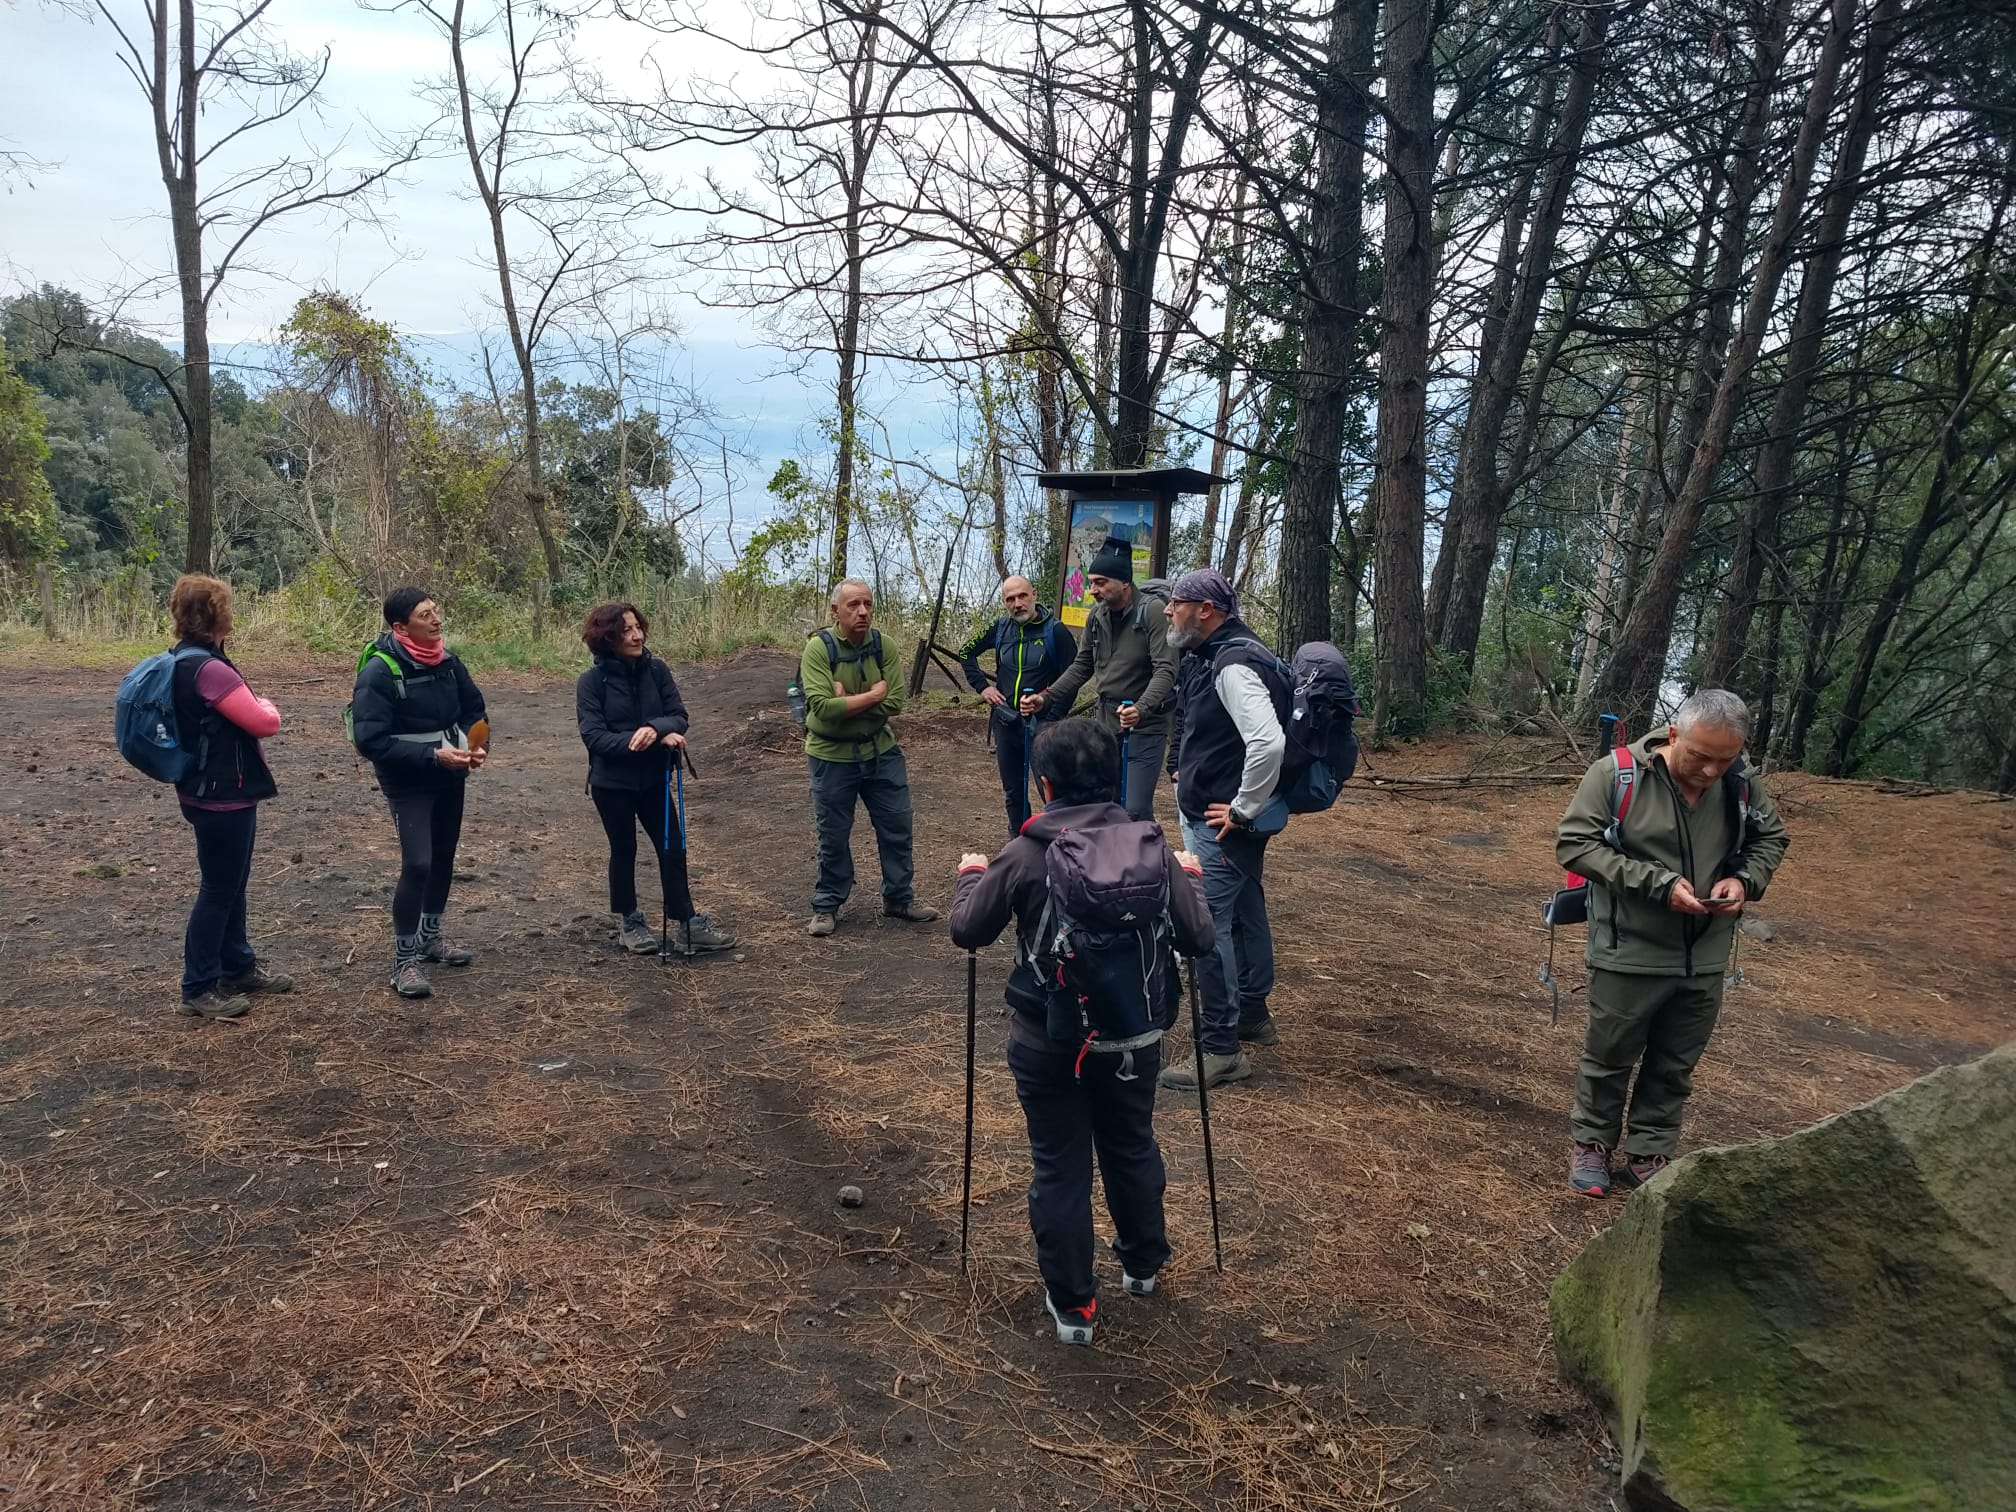
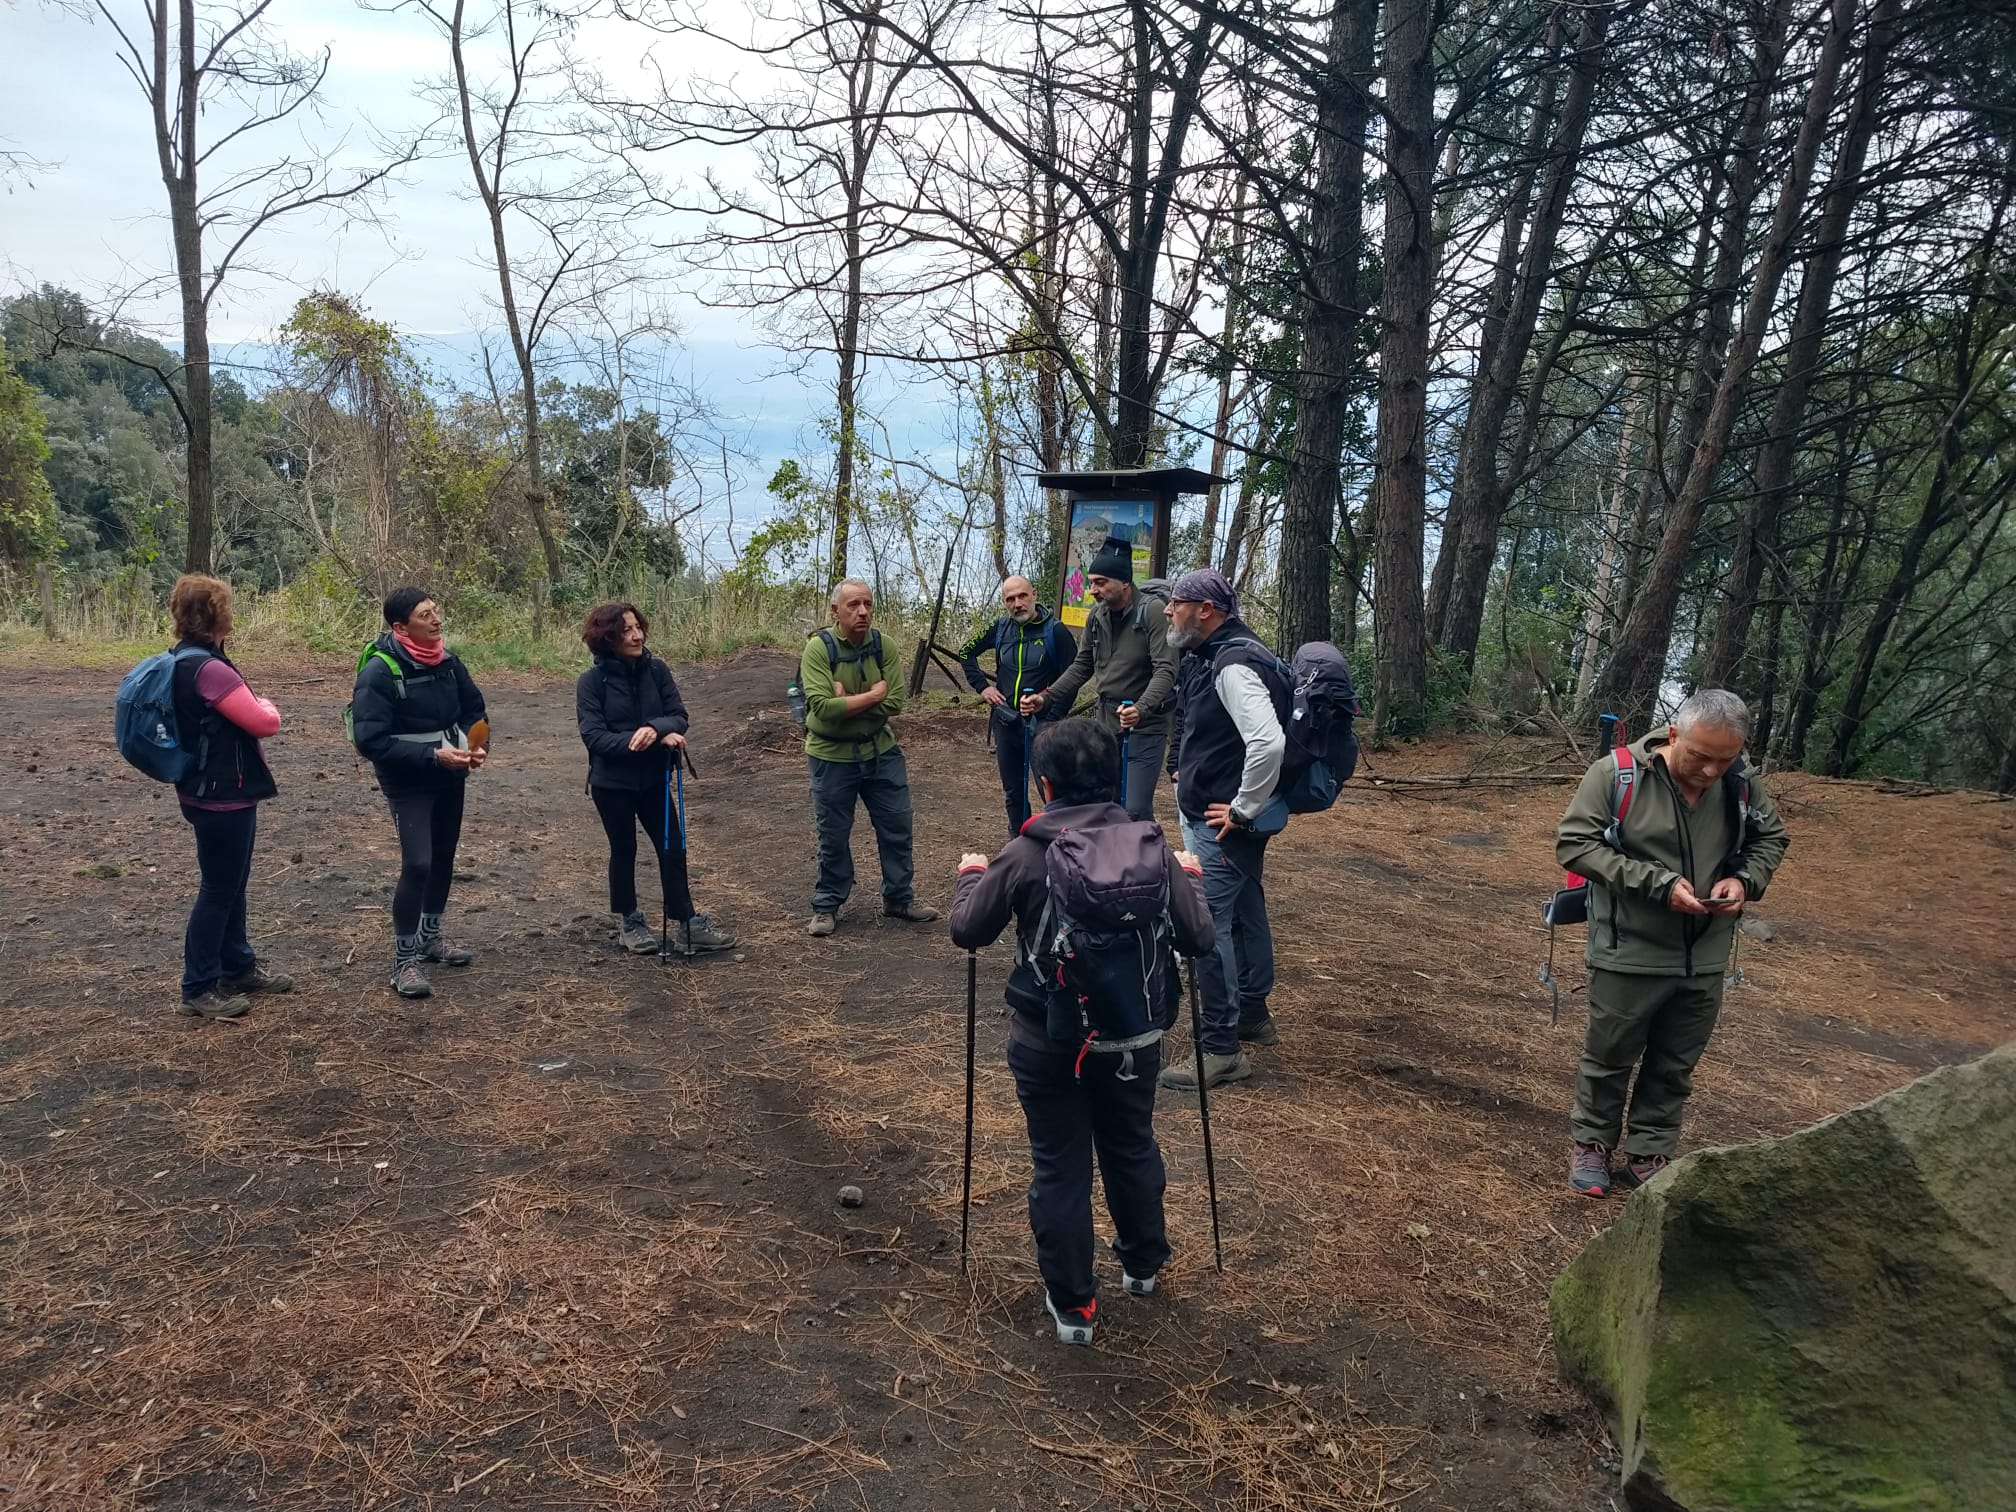
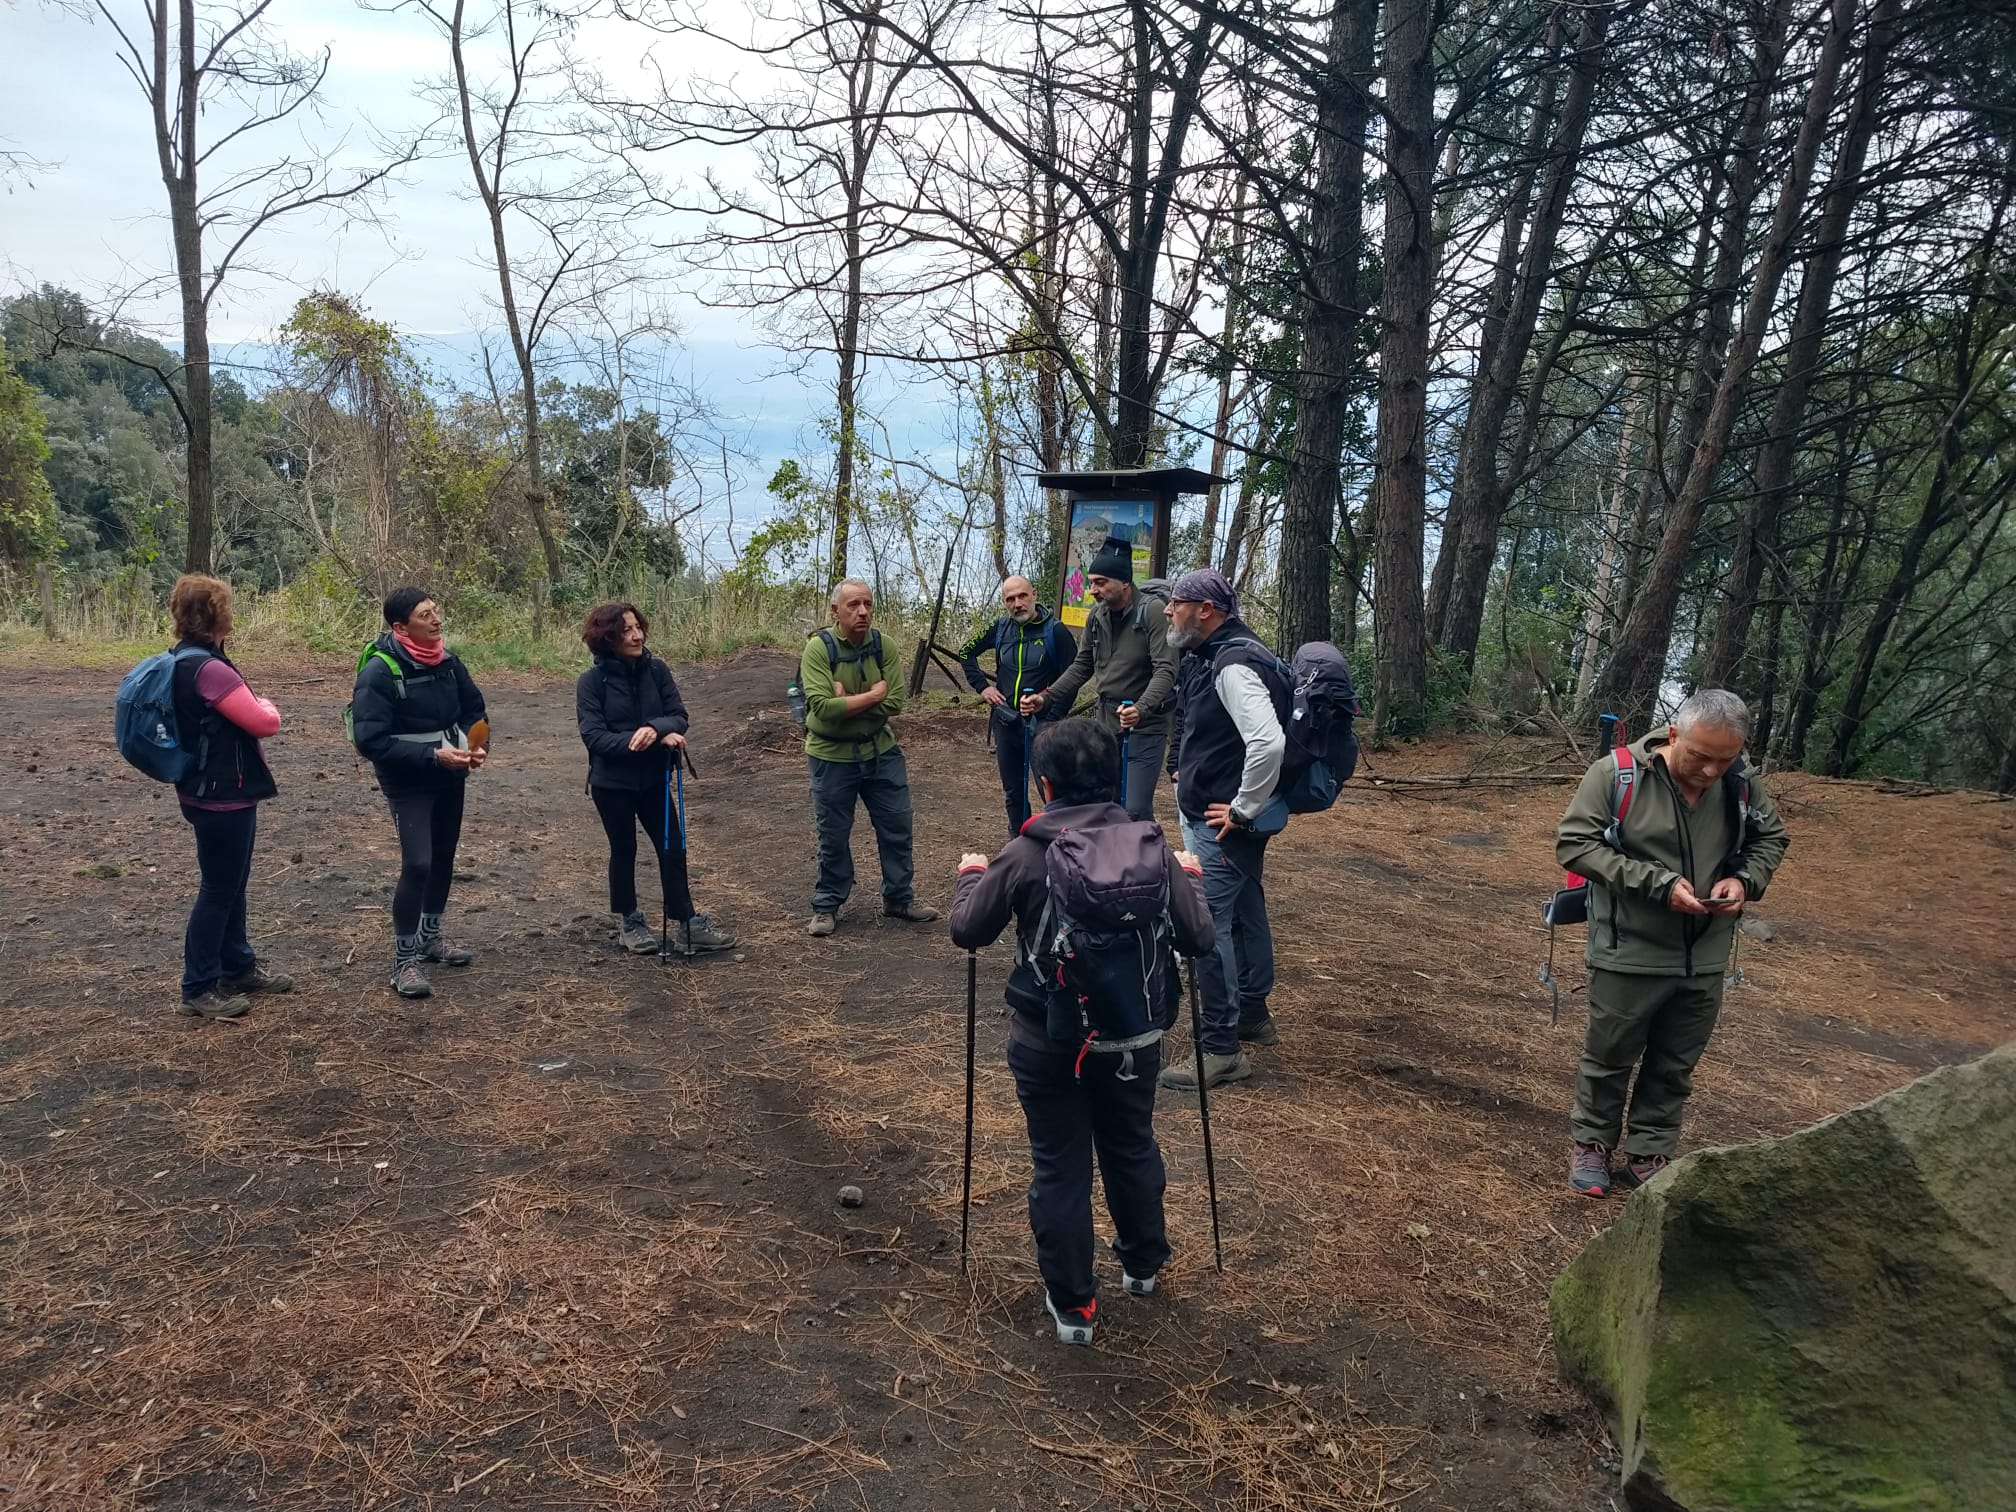
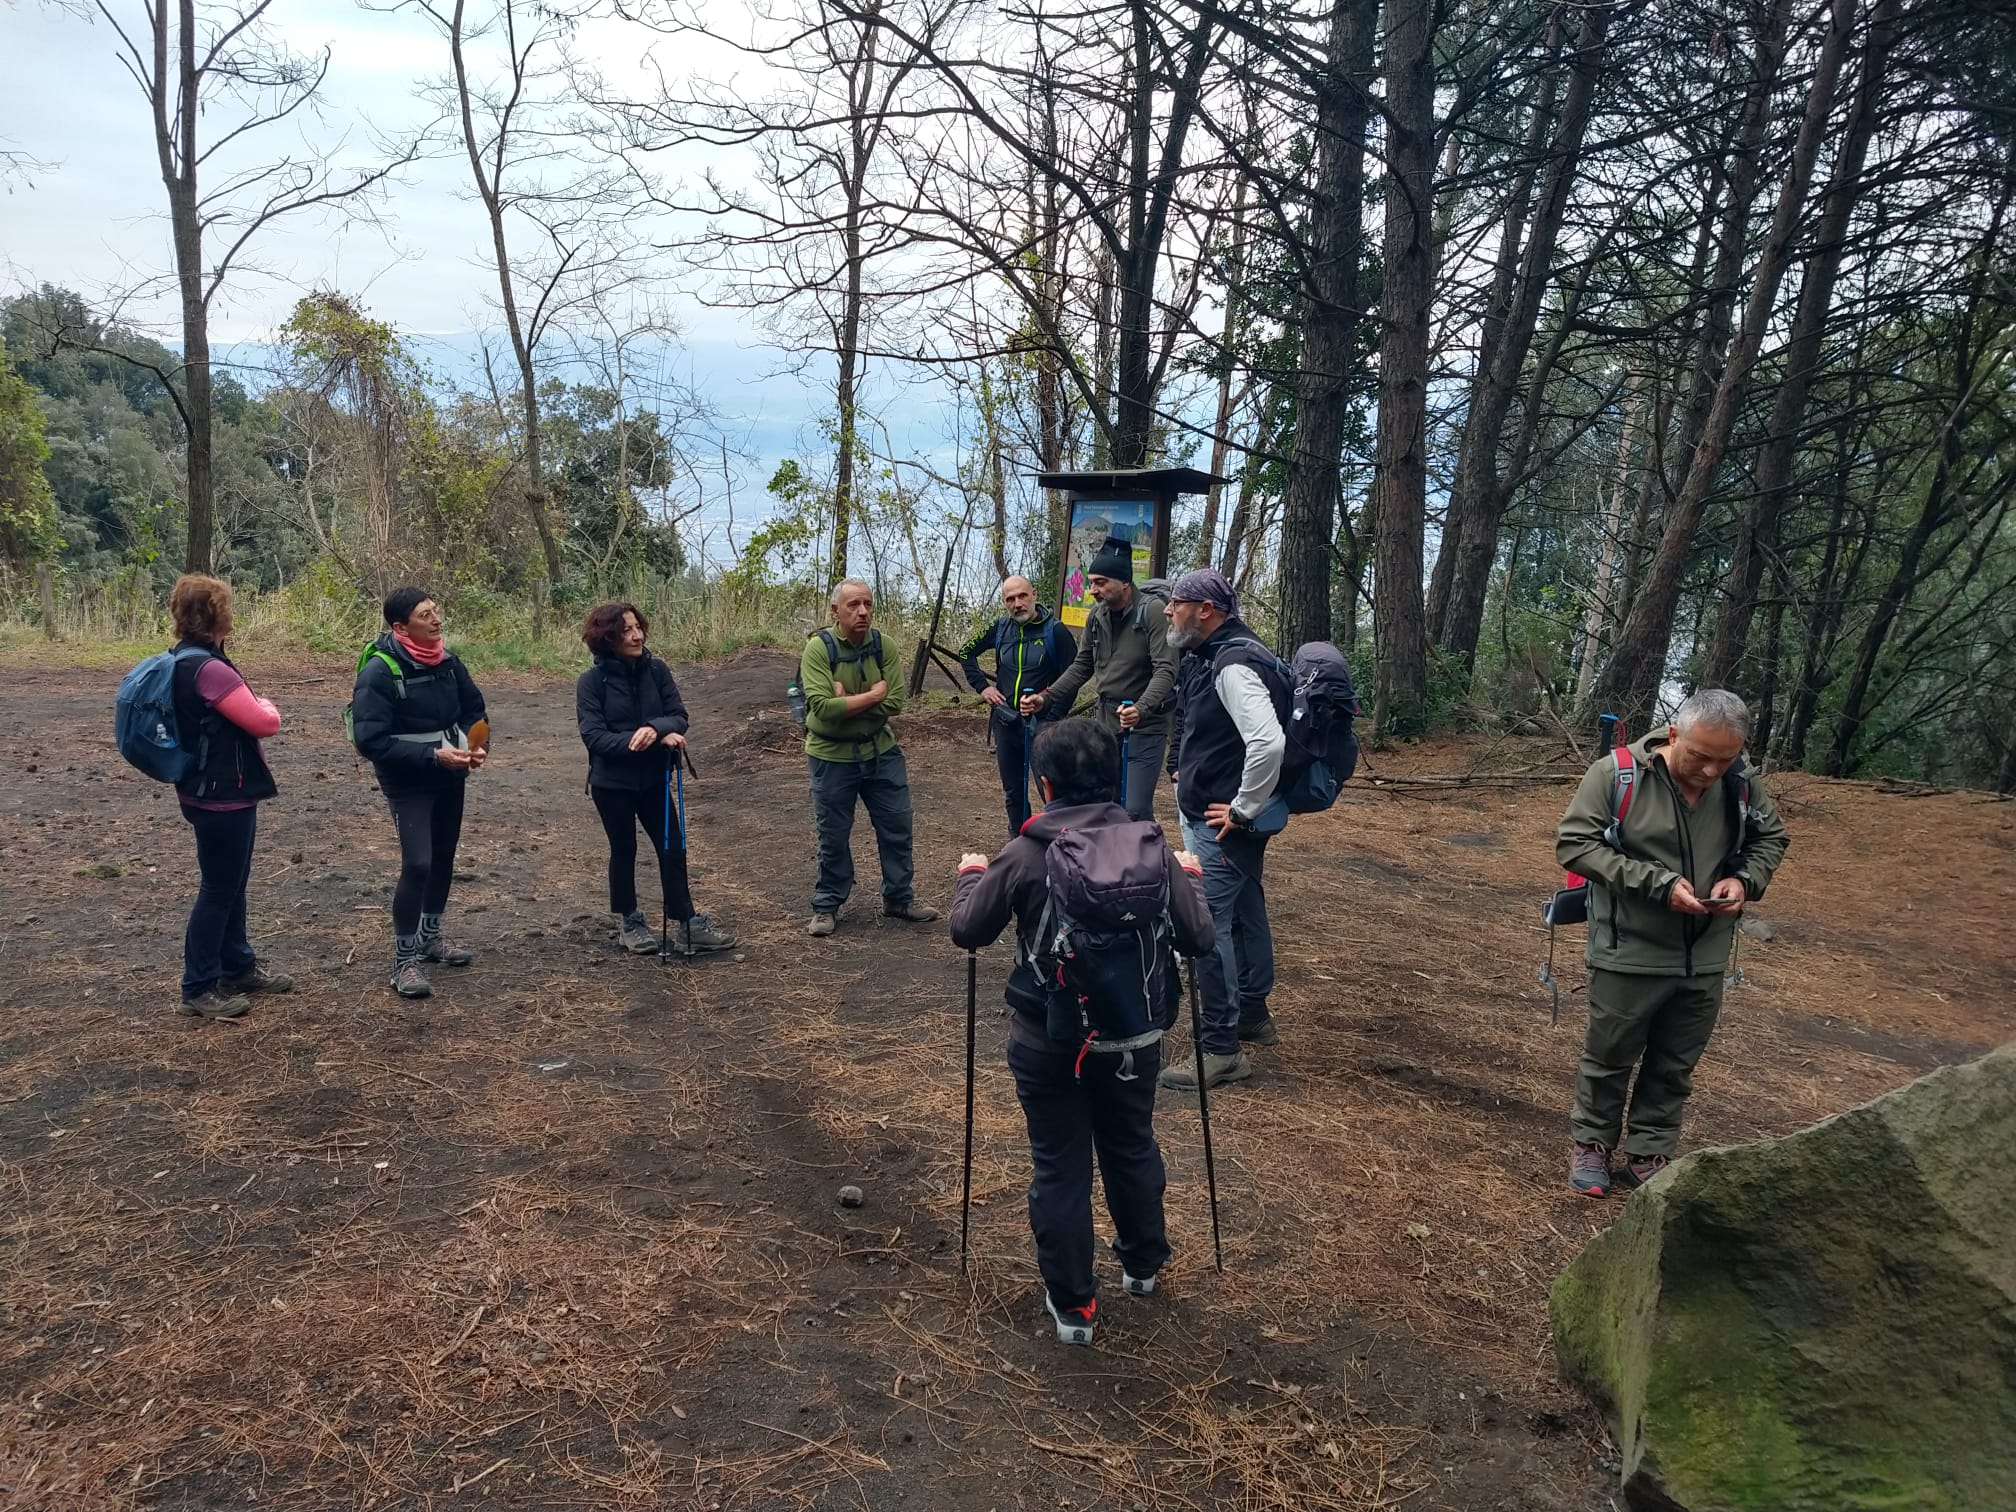
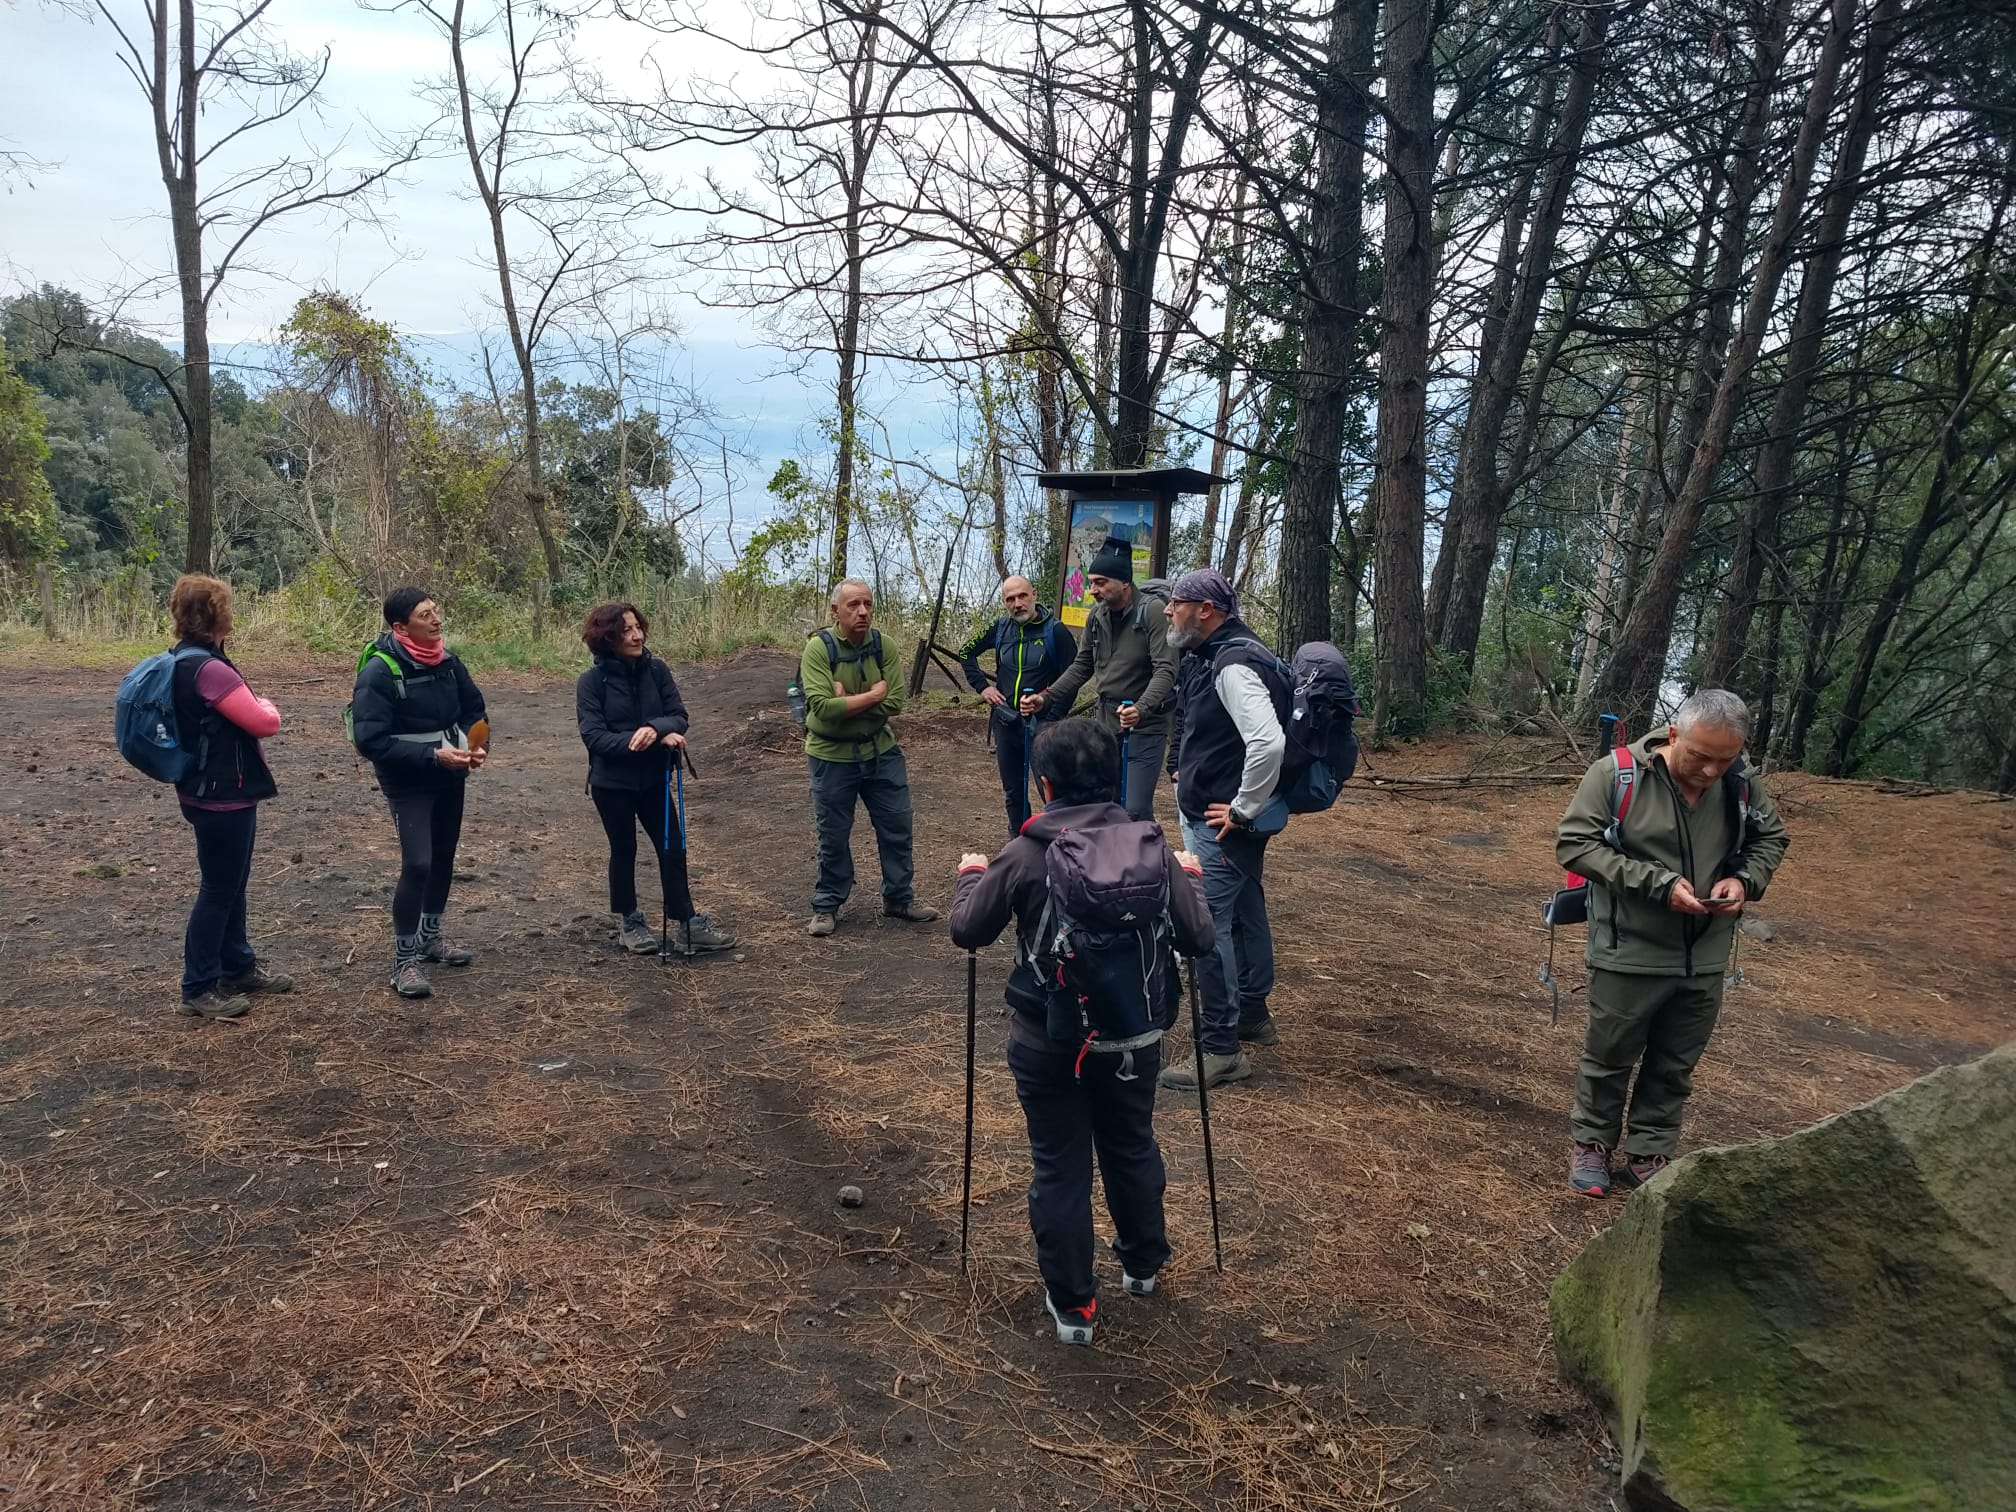

In [9]:
count = 0
for traccia in escursioniDF2["Traccia GPX"]:
    unpacked = process_gpx_to_df(str("./gpxFolder/") + traccia)
    
    # dati da inserire nel popup
    nomeEscursione = escursioniDF2["Escursione"][count]
    dataEscursione = escursioniDF2["  "][count]
    direttoreEscursione = escursioniDF2["Direttori di escursione"][count]; cellulare1 = escursioniDF2["Unnamed: 14"][count]
    codirettoreEscursione = escursioniDF2["Unnamed: 15"][count]; cellulare2 = escursioniDF2["Unnamed: 16"][count]
    tipologiaEscursione = escursioniDF2["Tipo"][count]
    
    dislivello = 0
    for x in np.around(unpacked[0]["Altitude"] - unpacked[0]["Altitude"].shift(1), 3):
        if x > 0:
            dislivello += x

    distanza = 0
    for n in np.arange(len(unpacked[1])-1):
        x1 = unpacked[1][n][0]; y1 = unpacked[1][n][1]; x2 = unpacked[1][n+1][0]; y2 = unpacked[1][n+1][1]    
        distanza += np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

    if type(escursioniDF2["Sezioni Ospitate"][count]) == str:
        sezioneAmica = escursioniDF2["Sezioni Ospitate"][count]
        daAggiungere = (f"<i>In compagnia della Sezione di {sezioneAmica} <br></i>")
    else:
        daAggiungere = ""
    
    html = f"<aa style=\"font-family:segoe UI\"> <titolo style=\"font-size: 24px;\"> <b>{nomeEscursione}</b> </titolo> <br>" + daAggiungere + f"<br><b>Data</b>: {dataEscursione} <br> <b>Direttori d'escursione</b>: {direttoreEscursione} ({cellulare1}), {codirettoreEscursione} ({cellulare2})  \
    <br> \
    <b>Difficoltà</b>: {escursioniDF2['Difficoltà'][count]}  - <b> Dislivello </b>: {np.around(dislivello,0)}m - <b> Distanza </b>: {np.around(distanza,2)*100}km - <b>{tipologiaEscursione}</b> \
    <br><br><br><br> \
    <lnk style=\"font-size: 18px\"> Per maggiori informazioni consultare la <a href = \"https://www.facebook.com\"> scheda tecnica </a> </lnk> </aa>"
    iframe = branca.element.IFrame(html=html, width=475, height=300)
    popup = f.Popup(iframe, parse_html = True, max_width=500)
    lat_start = unpacked[1][0][0]; long_start = unpacked[1][0][1]

    f.Marker(location=[lat_start, long_start], weight=1, popup=popup, icon = f.Icon(icon = "person-hiking", prefix="fa")).add_to(m)

    # traccia gpx
    f.PolyLine(unpacked[1], color=colors[count], weight=2.5, opacity=1).add_to(m)

    # IMAGE
    imageProva = "https://github.com/trarez/CAI/blob/main/slargoprisco.jpg?raw=true"

    # esempio foto
    f.Marker(location=[unpacked[1][145][0], unpacked[1][145][1]], \
             popup = add_image_to_popup(imageProva, '<a href="#"></a> <x style="font-size: 22px">Il reggente racconta riguardo Angelo Prisco</x>'), \
             icon = f.Icon(icon = "camera")).add_to(fg2)
    
    count += 1


# urlRosa = 'https://raw.githubusercontent.com/SECOORA/static_assets/master/maps/img/rose.png'
urlLogo = ('https://github.com/trarez/CAI/blob/main/Asset%202.png?raw=true')

FloatImage(urlLogo, bottom=88, left=1).add_to(m)
m

In [84]:
nomeEscursione = escursioniDF["Escursione"][15]
dataEscursione = escursioniDF["  "][15]
direttoreEscursione = escursioniDF["Direttori di escursione"][15]; cellulare1 = escursioniDF["Unnamed: 14"][15]
codirettoreEscursione = escursioniDF["Unnamed: 15"][15]; cellulare2 = escursioniDF["Unnamed: 16"][15]


html = f"<h3> {nomeEscursione} </h3> <b>Data</b>: {dataEscursione} <br> <b>Direttori d'escursione</b>: {direttoreEscursione} ({cellulare1}), {codirettoreEscursione} ({cellulare2})"
iframe = branca.element.IFrame(html=html, width=500, height=300)
popup = f.Popup(iframe, parse_html = True, max_width=500)

lat_start = prova1[1][0][0]; long_start = prova1[1][0][1]

# f.Marker(location = [lat_start, long_start], popup=popup).add_to(m)

f.vector_layers.CircleMarker(location=[lat_start, long_start], radius=9, color="white", weight=1, fill_color="green", fill_opacity=1, popup=popup).add_to(m)
m